In [11]:
ksize = 3 #3 or 5
lr = 1e-4 #1e-3 or 1e-4
transform_data = True #True or False
weigh_edges = True #Float or False

# Define 4-Layer Model


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tifffile as tiff
class DoubleConv(nn.Module):
    """
    Two consecutive convolutional layers each followed by BatchNorm and ReLU.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv, self).__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True) # standard double convolution
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        # ^ added residual layer



    def forward(self, x):
        return self.relu(self.block(x)+self.skip(x))


class UNet(nn.Module):
    """
    U-Net architecture for 512x512 inputs.
    Args:
        in_channels (int): number of input channels (e.g., 3 for RGB)
        out_channels (int): number of output channels (e.g., 1 for binary segmentation)
        init_features (int): number of features in the first layer
    """
    def __init__(self, in_channels=1, out_channels=1, init_features=64, ksize=3):
        super(UNet, self).__init__()
        features = [init_features, init_features*2, init_features*4, init_features*8, init_features*16]

        # Encoder
        self.encoder1 = DoubleConv(in_channels, features[0], ksize)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = DoubleConv(features[0], features[1], ksize)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = DoubleConv(features[1], features[2], ksize)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = DoubleConv(features[2], features[3], ksize)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = DoubleConv(features[3], features[4], ksize)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(features[4], features[3], kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features[4], features[3], ksize)
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features[3], features[2], ksize)
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features[2], features[1], ksize)
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features[1], features[0], ksize)

        # Final 1x1 convolution
        self.conv_last = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)        # -> [B, F, 512, 512]
        enc2 = self.encoder2(self.pool1(enc1))  # -> [B, 2F, 256, 256]
        enc3 = self.encoder3(self.pool2(enc2))  # -> [B, 4F, 128, 128]
        enc4 = self.encoder4(self.pool3(enc3))  # -> [B, 8F, 64, 64]
        bottleneck = self.bottleneck(self.pool4(enc4))  # -> [B, 16F, 32, 32]

        # Decoder path
        dec4 = self.upconv4(bottleneck)          # -> [B, 8F, 64, 64]
        dec4 = torch.cat((dec4, enc4), dim=1)     # skip connection
        dec4 = self.decoder4(dec4)               # -> [B, 8F, 64, 64]

        dec3 = self.upconv3(dec4)                # -> [B, 4F, 128, 128]
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)               # -> [B, 4F, 128, 128]

        dec2 = self.upconv2(dec3)                # -> [B, 2F, 256, 256]
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)               # -> [B, 2F, 256, 256]

        dec1 = self.upconv1(dec2)                # -> [B, F, 512, 512]
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)               # -> [B, F, 512, 512]

        return self.conv_last(dec1)


# Define 5-Layer Model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tifffile as tiff
class DoubleConv(nn.Module):
    """
    Two consecutive convolutional layers each followed by BatchNorm and ReLU.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv, self).__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True) # standard double convolution
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        # ^ added residual layer

    def forward(self, x):
        return self.relu(self.block(x)+self.skip(x))

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64, ksize=3):
        super(UNet, self).__init__()
        features = [
            init_features,         # 64
            init_features * 2,     # 128
            init_features * 4,     # 256
            init_features * 8,     # 512
            init_features * 16,    # 1024
            init_features * 32     # 2048
        ]

        # Encoder
        self.encoder1 = DoubleConv(in_channels, features[0], ksize)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features[0], features[1], ksize)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(features[1], features[2], ksize)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(features[2], features[3], ksize)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = DoubleConv(features[3], features[4], ksize)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[4], features[5], ksize)

        # Decoder
        self.upconv5 = nn.ConvTranspose2d(features[5], features[4], 2, 2)
        self.decoder5 = DoubleConv(features[5], features[4], ksize)
        self.upconv4 = nn.ConvTranspose2d(features[4], features[3], 2, 2)
        self.decoder4 = DoubleConv(features[4], features[3], ksize)
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], 2, 2)
        self.decoder3 = DoubleConv(features[3], features[2], ksize)
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], 2, 2)
        self.decoder2 = DoubleConv(features[2], features[1], ksize)
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], 2, 2)
        self.decoder1 = DoubleConv(features[1], features[0], ksize)

        # Final 1x1 convolution
        self.conv_last = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        bottleneck = self.bottleneck(self.pool5(enc5))

        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv_last(dec1)


#Define and Load Dataset

In [3]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
from skimage.segmentation import find_boundaries # to weigh edges

class SegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folder, image_transform=None, mask_transform=None):
        # Collect and sort file paths to ensure alignment
        # Gather all file paths
        image_files = glob.glob(os.path.join(image_folder, "*.tif"))
        mask_files = glob.glob(os.path.join(mask_folder, "*.png"))

        # Compute base filenames (without extension)
        image_names = {os.path.splitext(os.path.basename(p))[0] for p in image_files}
        mask_names = {os.path.splitext(os.path.basename(p))[0] for p in mask_files}

        # Keep only those with a matching counterpart
        common_names = image_names & mask_names
        self.image_paths = sorted([p for p in image_files if os.path.splitext(os.path.basename(p))[0] in common_names])
        self.mask_paths  = sorted([p for p in mask_files   if os.path.splitext(os.path.basename(p))[0] in common_names])

        assert len(self.image_paths) == len(self.mask_paths), "Number of images and masks must match"
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load grayscale image and mask
        image = tiff.imread(self.image_paths[idx])
        if image.dtype != np.uint8:
          # Normalize to [0, 255] and convert to uint8 for PIL
          image = (image - image.min()) / (image.max() - image.min() + 1e-8)
          image = (image * 255).astype(np.uint8)

        # Convert to PIL image for torchvision transforms
        image = Image.fromarray(image)
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            # Ensure binary mask (0 or 1)
            mask = (mask > 0.5).float()

        if transform_data:
          angle = random.choice([0, 90, 180, 270])
          image = transforms.functional.rotate(image, angle)
          mask = transforms.functional.rotate(mask, angle)

        if weigh_edges:
          mask_np = mask.squeeze().numpy().astype(np.uint8)  # [H, W] binary
          boundary = find_boundaries(mask_np, mode='inner').astype(np.float32)
          weight_map = 1.0 + weigh_edges * torch.from_numpy(boundary)  # boost weight on edges (1 → 3)

        # Return all three
        return image, mask, weight_map.unsqueeze(0)  # make weight map shape [1, H, W]

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),               # [1, 512, 512], values in [0,1]
    #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.01, 0.5)),
    transforms.Normalize([0.5], [0.5])   # Normalize to [-1, 1]
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.ToTensor()                # [1, 512, 512], values in [0,1]
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Instantiate dataset
dataset = SegmentationDataset(
    image_folder='/content/drive/MyDrive/ML_Final_Dataset/tif',
    mask_folder='/content/drive/MyDrive/ML_Final_Dataset/seg',
    image_transform=image_transform,
    mask_transform=mask_transform
)

In [6]:
from tqdm.auto import tqdm
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch.multiprocessing as mp

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1, init_features=64, ksize=ksize).to(device)

torch.manual_seed(42)

# Define split ratio
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size  # 20% test
valid_size = int(0.2 * train_size)  # 20% validation
x_size = train_size - valid_size

# Split the dataset
X_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset, validation_dataset = random_split(X_dataset, [x_size, valid_size])

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=4)

# Train Model

Training:   0%|          | 0/78 [00:00<?, ?batch/s]

Epoch 1/30 — Loss: 0.3152


Validating:   0%|          | 0/20 [00:00<?, ?batch/s]

Validation Loss: 0.0889


Training:   0%|          | 0/78 [00:00<?, ?batch/s]

Epoch 2/30 — Loss: 0.0839


Validating:   0%|          | 0/20 [00:00<?, ?batch/s]

Validation Loss: 0.0835


Training:   0%|          | 0/78 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/30 — Loss: 0.0701


Validating:   0%|          | 0/20 [00:00<?, ?batch/s]

Validation Loss: 0.0768


Training:   0%|          | 0/78 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/30 — Loss: 0.0603


Validating:   0%|          | 0/20 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c5ce13f8900>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._par

Validation Loss: 0.0821


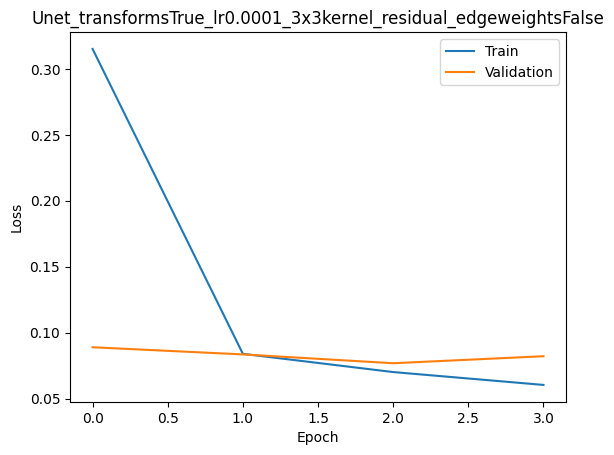

In [7]:
import pandas as pd

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 30
loss_over_training = []
val_over_training = []
last_val_loss = float('inf')

model_name = f"Unet_transforms{transform_data}_lr{lr}_{ksize}x{ksize}kernel_residual_edgeweightsFalse"
model_path = f"/content/drive/MyDrive/ml_final/{model_name}"

os.mkdir(model_path)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc="Training", unit="batch")
    for images, masks, weights in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Each iteration, reset the description to include batch count
        loop.set_description(f"Epoch {epoch}/{num_epochs}  Batch {loop.n}/{len(train_loader)}")
        # Optionally, still show current loss
        loop.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_over_training.append(epoch_loss)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {epoch_loss:.4f}")
    model.eval()

    val_loss = 0.0
    epsilon = 1e-6  # to avoid zero division

    with torch.no_grad():
        # Wrap in tqdm to monitor progress over test set
        loop = tqdm(validation_loader, desc="Validating", unit="batch")
        for images, masks, weights in loop:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Compute binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Compute Dice coefficient per batch
            intersection = (preds * masks).sum(dim=(1,2,3))
            loop.set_description(f"Batch {loop.n}/{len(validation_loader)}")
            loop.set_postfix(loss=f"{loss.item():.4f}")
        num_samples = len(validation_loader.dataset)
        avg_val_loss = val_loss / num_samples
        val_over_training.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
    last_epoch = epoch
    if last_val_loss < avg_val_loss:
        break
    last_val_loss = avg_val_loss
    torch.save(model.state_dict(), f"{model_path}/model.pth")

# Optionally save the trained model

plt.plot(loss_over_training)
plt.plot(val_over_training)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(model_name)
plt.legend(['Train', 'Validation'])
df = pd.DataFrame(loss_over_training)
df.to_csv(f'{model_path}/train_loss.csv')
df = pd.DataFrame(val_over_training)
df.to_csv(f'{model_path}/val_loss.csv')
plt.show()

# Test Model

In [15]:
import torch
from tqdm.auto import tqdm

# Assume: model, test_loader, criterion, device are already defined

# Switch model to evaluation mode
model.load_state_dict(torch.load('/content/drive/MyDrive/ml_final/Unet_transformsTrue_lr0.0001_3x3kernel_residual/model.pth'))
model.eval()


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
test_loss = 0.0
dice_score = 0.0
epsilon = 1e-6  # to avoid zero division

with torch.no_grad():
    # Wrap in tqdm to monitor progress over test set
    loop = tqdm(test_loader, desc="Evaluating", unit="batch")
    for images, masks, weights in loop:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Compute binary predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Compute Dice coefficient per batch
        intersection = (preds * masks).sum(dim=(1,2,3))
        total = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
        batch_dice = ((2 * intersection + epsilon) / (total + epsilon)).mean()
        dice_score += batch_dice.item() * images.size(0)

# Aggregate results
num_samples = len(test_loader.dataset)
avg_loss = test_loss / num_samples
avg_dice = dice_score / num_samples

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Dice Score: {avg_dice:.4f}")


Evaluating:   0%|          | 0/25 [00:00<?, ?batch/s]

Test Loss: 0.0427
Test Dice Score: 0.7354


# Visualize Output

-1.0 0.99215686
-1.0 0.99215686
0.0 1.0
1.4334511e-06 0.9927382


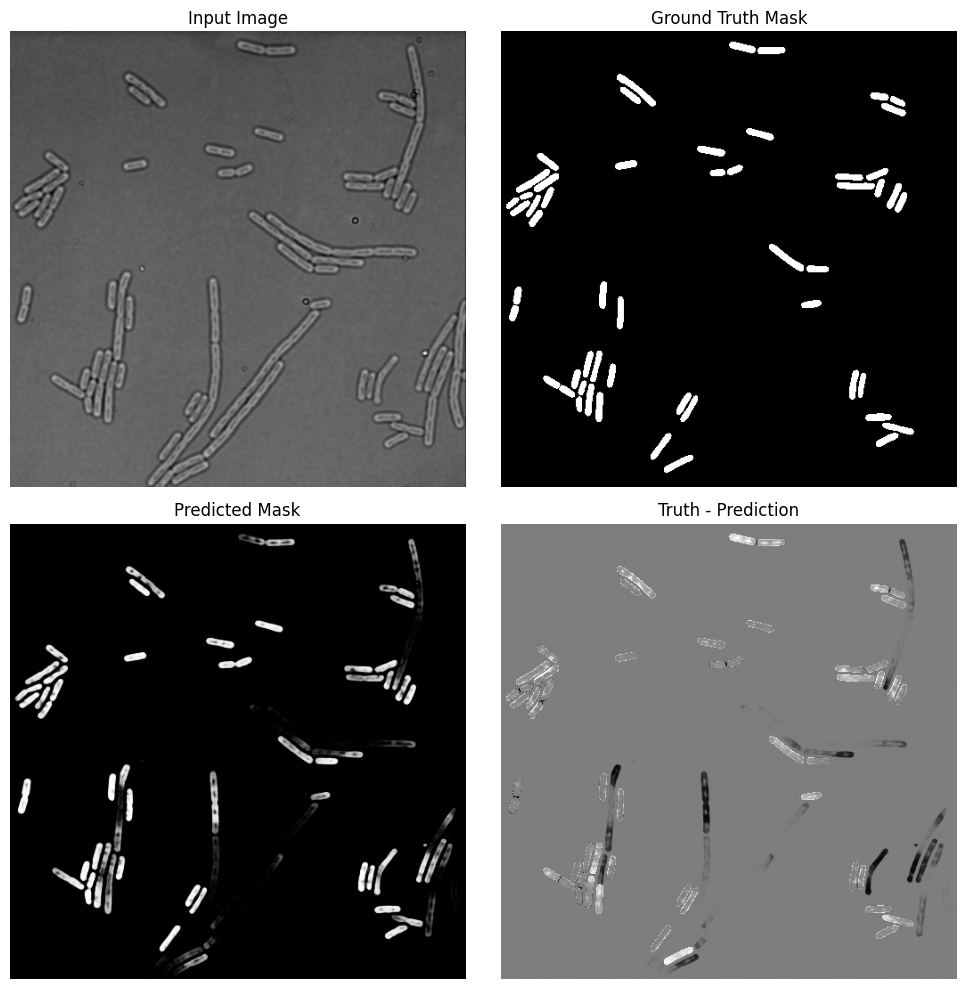

In [17]:
index = random.randint(0, len(dataset)-1)
image_tensor, mask_tensor, w = dataset[index]

# Convert tensors to numpy arrays for plotting
image_np = image_tensor.squeeze().numpy()  # shape: [512, 512]
print(image_np.min(),image_np.max())
mask_np = mask_tensor.squeeze().numpy()    # shape: [512, 512]

input_tensor = image_tensor.unsqueeze(0).to(device)

# Set model to evaluation mode and run inference
#model.load_state_dict(torch.load('/content/drive/MyDrive/ml_final/Unet_transformsTrue_lr0.0001_3x3kernel_5layer/model.pth'))

model.eval()
with torch.no_grad():
    yhat = model(input_tensor)
    yhat = torch.sigmoid(yhat)  # if not already sigmoid inside the model
    #yhat = (yhat > 0.5).float()

# Convert tensors to numpy
image_np = image_tensor.squeeze().numpy()  # [512, 512]
mask_np = mask_tensor.squeeze().numpy()    # [512, 512]
pred_np = yhat.squeeze().cpu().numpy()     # [512, 512]

print(image_np.min(),image_np.max())
print(mask_np.min(),mask_np.max())
print(pred_np.min(),pred_np.max())

# Plot input, mask, and predicted mask
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].imshow(image_np * 0.5 + 0.5, cmap='gray')
axs[0][0].set_title("Input Image")
axs[0][0].axis("off")

axs[0][1].imshow(mask_np, cmap='gray')
axs[0][1].set_title("Ground Truth Mask")
axs[0][1].axis("off")

axs[1][0].imshow(pred_np, cmap='gray')
axs[1][0].set_title("Predicted Mask")
axs[1][0].axis("off")

# Optional: leave the last subplot blank or use for something else
axs[1][1].imshow(mask_np-pred_np,cmap='gray')
axs[1][1].set_title("Truth - Prediction")
axs[1][1].axis("off")

plt.tight_layout()
plt.show()

#Visualize Model Performance

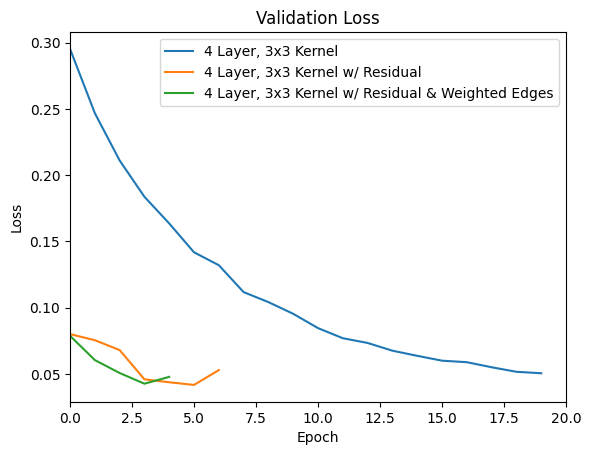

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
standard_path = '/content/drive/MyDrive/ml_final/Unet_transformsTrue_lr0.0001_3x3kernel'
deeper_path = '/content/drive/MyDrive/ml_final/Unet_transformsTrue_lr0.0001_3x3kernel_residual_edgeweights0.5'
kernel_path = '/content/drive/MyDrive/ml_final/Unet_transformsTrue_lr0.0001_3x3kernel_residual'
std_val = pd.read_csv(standard_path + '/val_loss.csv')
deeper_val = pd.read_csv(kernel_path + '/val_loss.csv')
kernel_val = pd.read_csv(deeper_path + '/val_loss.csv')
plt.plot(std_val['0'],label='4 Layer, 3x3 Kernel')
plt.plot(deeper_val['0'],label='4 Layer, 3x3 Kernel w/ Residual')
plt.plot(kernel_val['0'],label='4 Layer, 3x3 Kernel w/ Residual & Weighted Edges')
plt.legend()
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0,20)
plt.show()